In [1]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import Dissim, MinMax
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_SIZE = 10, 4.5
YEARS = [1880, 1883, 1885, 1888, 1890, 1895, 1900, 1902, 1905, 1910, 1913, 1915]
BAD_YEARS = [1885, 1890, 1905, 1910]
BWS = 150, 200, 250
CELL_SIZE = 20

AREAS = {
    'Old town': ['Valli', 'Valli_uusi'],
    'New districts': ['Pietarin_esikaupunki', 'Repola', 'Anina', 'Pantsarlahti'],
    'All suburbs': ['Viipurin_esikaupunki', 'Pietarin_esikaupunki', 'Repola', 'Anina', 'Papula', 'Pantsarlahti', 'Salakkalahti'],
    'Vyborg suburb': ['Viipurin_esikaupunki'],
    'Salakkalahti': ['Salakkalahti'],
    'Papula': ['Papula'],
    'Valli, new': ['Valli_uusi'],
    'Valli, old': ['Valli'],
}
CENTER = Point(594438, 6732187)

/home/antth/anaconda3/envs/spatial_segregation/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
        bounds: tuple,
        pad=0,
):
    pop = get_xy(data)

    minx, miny, maxx, maxy = bounds
    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad
    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)
    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': density.dtype,
        'width': density.shape[1],
        'height': density.shape[0],
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        **kwargs
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bounds=data.geometry.total_bounds,
        pad=50,
        **kwargs
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bounds=data.geometry.total_bounds,
        pad=50,
        **kwargs
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [3]:

def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]

    for idx in institutions.index:
        pop_data = pop_data.drop(index=idx, errors='ignore')

    return pop_data


def handle_combined_plots(
        pop_data: pd.DataFrame,
        target_column: str = 'plot_number',
):
    target_shape = pop_data.shape
    index_columns = pop_data.index.names
    pop_data.reset_index(inplace=True)
    pop_data[target_column] = [e.split(',')[0].strip() for e in pop_data[target_column]]
    pop_data.set_index(index_columns, inplace=True)

    assert pop_data.shape == target_shape

    return pop_data


def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:
    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)
    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)
    return pop_frame


In [4]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [5]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

In [6]:
warnings.simplefilter(action='ignore')

district_codes = pd.read_csv(DATA_DIR / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(DATA_DIR / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(DATA_DIR / 'raw' / 'plots_1878.gpkg').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(DATA_DIR / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

In [7]:
results_dict = {}
for year in YEARS:
    s_ = []
    if year in BAD_YEARS:
        continue
    for bw in BWS:
        population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)

        for group in 'orthodox', 'lutheran', 'total':
            file = DATA_DIR / 'processed' / f"{group}_density_{year}_{bw}m.tif"
            if file.exists():
                continue
            
            density, raster_args = kernel_density_surface(
                page_location_data,
                group=group,
                bandwidth=bw,
                cell_size=CELL_SIZE,
                kernel_function=quartic_kernel,
                bounds=page_location_data.geometry.total_bounds,
            )
            density = density * 10_000

            with rio.open(file, 'w', **raster_args) as rfile:
                rfile.write(density, 1)
        
        S = get_S(
            data=page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel, 
        )
        s_.append(S.statistic)

    results_dict[year] = s_

results = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=BWS,
)

In [8]:
results_dict = {}
for year in (1880, 1900, 1915):
    s_ = []
    population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_plot_{year}.csv',
        index_col=0,
        dtype={'district': str, 'plot_number': str},
    ).pipe(prepare_pop_data)
    population_data = population_data.set_index(['district', 'plot_number'], drop=True)
    population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
    combined_data = location_data.join(population_data, on=['district', 'plot_number'])
    combined_data.dropna(axis=0, inplace=True)
    valli_data = combined_data.loc[AREAS['Old town']].copy()
    for bw in BWS:
        for group in 'orthodox', 'lutheran', 'total':
            file = DATA_DIR / 'processed' / f"{group}_density_Valli_{year}_{bw}m.tif"
            if file.exists():
                continue
            density, raster_args = kernel_density_surface(
                valli_data,
                group=group,
                bandwidth=bw,
                cell_size=CELL_SIZE,
                kernel_function=quartic_kernel,
                bounds=valli_data.geometry.total_bounds,
            )
            density = density * 10_000
            with rio.open(file, 'w', **raster_args) as rfile:
                rfile.write(density, 1)
        
        S = get_S(
            data=valli_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        s_.append(S.statistic)

    results_dict[year] = s_

valli_results = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=BWS,
)

In [9]:
# Results by district
results_dict = {}
for year in YEARS:
    if year in BAD_YEARS:
        continue
    bw = 150
    population_data = pd.read_csv(
        DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
        index_col=0,
        dtype={'district': str, 'representative_plot': str, 'page_number': str},
    ).pipe(prepare_pop_data)
    population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
    population_data = population_data.set_index(['district', 'plot_number'], drop=True)
    population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
    page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
    page_location_data.dropna(axis=0, inplace=True)

    s_ = {}
    # for district in page_location_data.index.levels[0]:
        # area_data = page_location_data.loc[district].copy()
    for area, districts in AREAS.items():
        area_data = page_location_data.loc[districts].copy()
        S = get_S(
            data=area_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        s_[area] = S.statistic

    results_dict[year] = s_

results_by_district = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=list(AREAS),
)

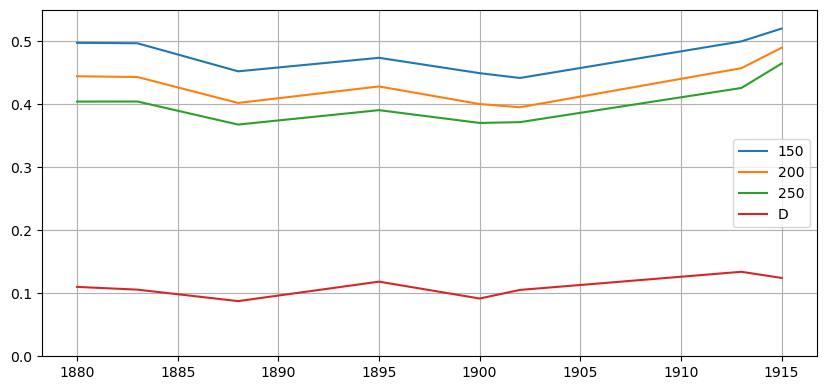

In [10]:
districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

results_D = {}

for year in YEARS:
    if year in BAD_YEARS:
        continue

    population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
    population_data = population_data[population_data.district.isin(districts_in_city)]
    population_data = population_data.loc[:, ['district', 'lutheran', 'orthodox', 'total']].groupby('district').sum()
    totals = pd.Series(population_data.sum(axis=0), name='totals')
    population_data = population_data.append(totals)

    D = Dissim(
        population_data,
        group_pop_var='orthodox',
        total_pop_var='total',
    )
    results_D[year] = D.statistic

results['D'] = pd.Series(results_D)
results.to_csv(DATA_DIR / 'processed' / 'results.csv')
# results.drop(labels=BAD_YEARS, axis=0, inplace=True)
results.plot(
    figsize=FIG_SIZE,
    subplots=False,
    grid=True,
    ylim=(0,0.55)
)
# for ax in axes:
    # ticks = np.arange(0, 1, 0.05)
    # ax.set_yticks(ticks)
    # ax.autoscale_view()
plt.savefig(FIG_DIR / 'S_and_D.png')

In [11]:
# individual impact

def loo_data_generator(
    data: pd.DataFrame,
):
    for idx in data.index:
        clipped = data.drop(index=idx)
        yield idx, clipped

def individual_impact(
    data: pd.DataFrame,
    **kwargs
)-> pd.Series:
    S_normal = get_S(
        data=data,
        **kwargs
    )
    statistics = {}
    for (idx, clipped_data) in loo_data_generator(data):
        S = get_S(
            data=clipped_data,
            **kwargs
        )
        statistics[idx] = S.statistic
    impact = S_normal.statistic - pd.Series(statistics)
    impact.name = 'S'
    return impact.round(5)

In [12]:
results = {}
for year in YEARS:
    if year in BAD_YEARS:
        continue
    for bw in BWS:
        output_file = DATA_DIR / 'processed' / f'S_impact_{year}_{bw}m.csv'
        if output_file.exists():
            continue
    
        population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)
        impact = individual_impact(
            page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        impact.to_csv(output_file)

       S_impact_1880_200m  S_impact_1883_200m  S_impact_1888_200m  \
count          131.000000          129.000000          150.000000   
mean            -0.000651           -0.000680           -0.000564   
std              0.003757            0.003756            0.003277   
min             -0.014120           -0.013270           -0.009380   
25%             -0.002920           -0.002850           -0.002485   
50%             -0.001130           -0.001060           -0.000815   
75%              0.001725            0.002080            0.001687   
max              0.010140            0.007180            0.008120   

       S_impact_1895_200m  S_impact_1900_200m  S_impact_1902_200m  \
count          206.000000          326.000000          309.000000   
mean            -0.000290           -0.000227           -0.000309   
std              0.002520            0.002290            0.002392   
min             -0.009770           -0.017420           -0.017200   
25%             -0.001757        

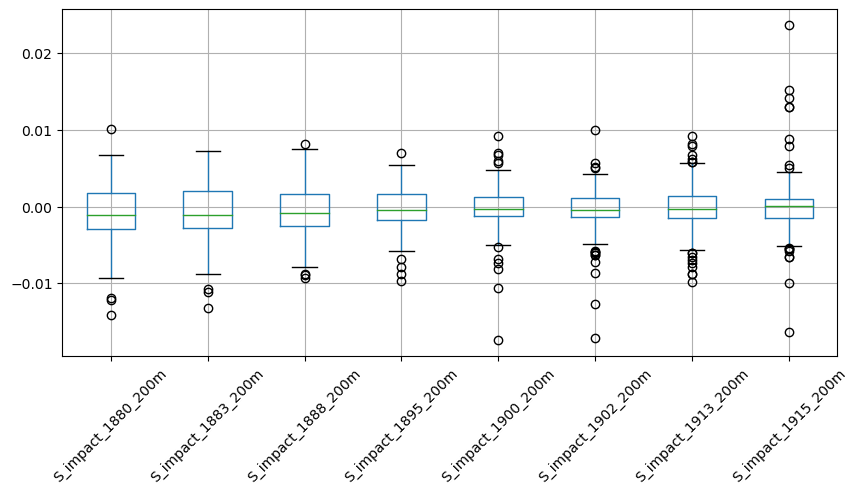

In [13]:
impact_list = []
for file in (DATA_DIR / 'processed').glob('S_impact*200m.csv'):
    impact = pd.read_csv(file, index_col=(0, 1), header=0, names=[file.stem])
    sorted_ = impact.sort_values(by=file.stem)
    impact_list.append(sorted_)

impacts = pd.concat(impact_list)
print(impacts.describe())

impacts.boxplot(rot=45, figsize=FIG_SIZE)
plt.show()

In [14]:
results = {}
for year in (1880, 1900, 1915):
    for bw in 150,:
        output_file = DATA_DIR / 'processed' / f'S_impact_Valli_{year}_{bw}m.csv'
        if output_file.exists():
            continue
    
        population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_plot_{year}.csv',
            index_col=0,
            dtype={'district': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)
        impact = individual_impact(
            page_location_data.loc[AREAS['Valli']].copy(),
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        impact.to_csv(output_file)

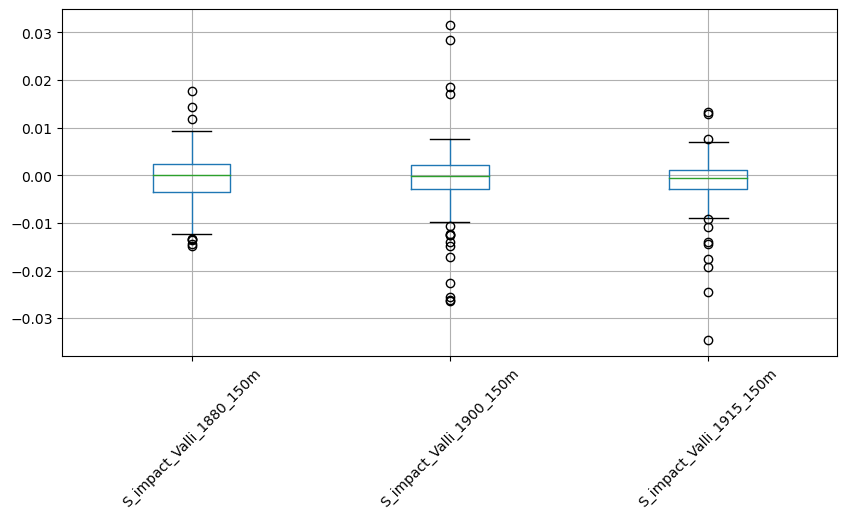

In [15]:
impact_list = []
for file in (DATA_DIR / 'processed').glob('S_impact_Valli*150m.csv'):
    impact = pd.read_csv(file, index_col=(0, 1), header=0, names=[file.stem])
    sorted_ = impact.sort_values(by=file.stem)
    impact_list.append(sorted_)
    # print(sorted_)

impacts = pd.concat(impact_list)

impacts.boxplot(rot=45, figsize=FIG_SIZE)
plt.show()

<AxesSubplot: >

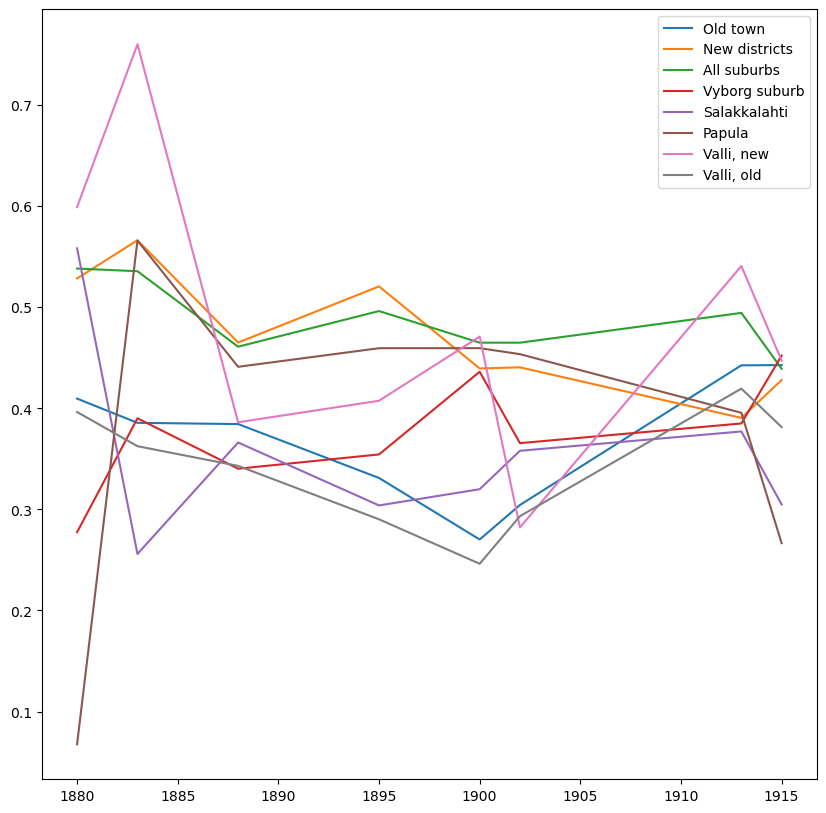

In [16]:
results_by_district.plot(figsize=(10, 10))

# Spline model

$$ S_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \sum_{k=1}^K w_k B_{k,i} $$
$$ B = \begin{bmatrix}
       1 & 0.687 & 0.295 & 0.02  & 0     & 0     & 0     & 0 \\
       0 & 0.299 & 0.601 & 0.612 & 0.367 & 0.276 & 0.007 & 0 \\
       0 & 0.015 & 0.104 & 0.367 & 0.612 & 0.658 & 0.209 & 0 \\
       0 & 0     & 0     & 0     & 0.02  & 0.066 & 0.784 & 1
       \end{bmatrix} $$
$$ w_k \sim Normal(0, 0.1) $$
$$ \alpha \sim Normal(0.45, 0.01) $$
$$ \sigma \sim HalfNormal(0.05) $$


In [17]:
import arviz as az
import pymc as pm
from patsy import dmatrix

regression_data = pd.read_csv(DATA_DIR / 'processed' / 'results.csv', index_col=0)
regression_data.loc[regression_data.index.isin(BAD_YEARS),:] = np.nan
regression_data = regression_data.dropna(axis=0)
n = regression_data.shape[0]
degree = 2
n_knots = 3

knot_list = np.linspace(regression_data.index.min(), regression_data.index.max(), n_knots)[1:-1]
B = dmatrix(
    "bs(year, knots=knots, degree=degree, include_intercept=True) - 1",
    {"year": regression_data.index, "knots": knot_list, "degree": degree},
)
w_len = B.shape[1]
np.asarray(B).T.round(3)

array([[1.   , 0.687, 0.295, 0.02 , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.299, 0.601, 0.612, 0.367, 0.276, 0.007, 0.   ],
       [0.   , 0.015, 0.104, 0.367, 0.612, 0.658, 0.209, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.02 , 0.066, 0.784, 1.   ]])

Text(0, 0.5, 'basis')

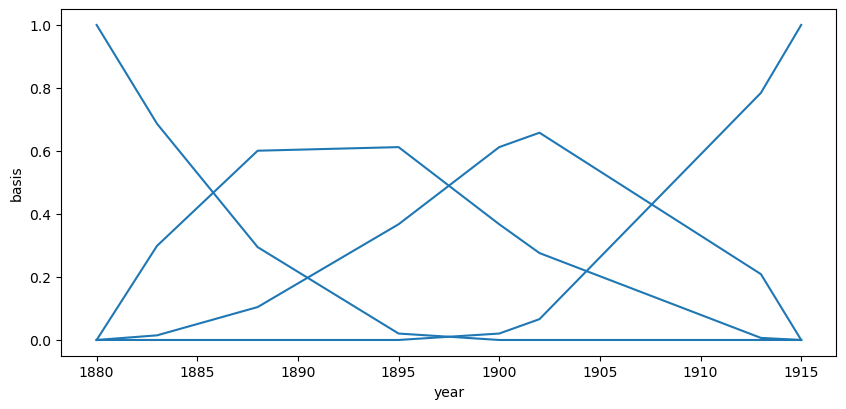

In [18]:
# Basis
_, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
for i in range(w_len):
    ax.plot(regression_data.index, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis")

In [19]:
σ_σ = 0.05
μ_a = 0.45
σ_a = 0.01
μ_w = [0] * w_len
σ_w = 0.1

In [20]:
with pm.Model() as model:
    a = pm.Normal("α", μ_a, σ_a)
    w = pm.Normal("w", mu=μ_w, sigma=σ_w, shape=B.shape[1])
    μ = pm.Deterministic("μ", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    σ = pm.HalfNormal('σ', σ_σ)
    S = pm.Normal("S", μ, σ, observed=regression_data['200'])
    idata = pm.sample(1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [21]:
with model:
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(idata)

Sampling: [S, w, α, σ]
Sampling: [S]


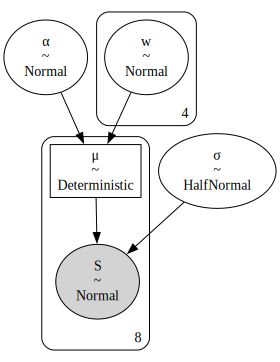

In [22]:
graph = pm.model_to_graphviz(model)
graph.format = 'svg'
graph.render(FIG_DIR / 'plate_diagram')
graph

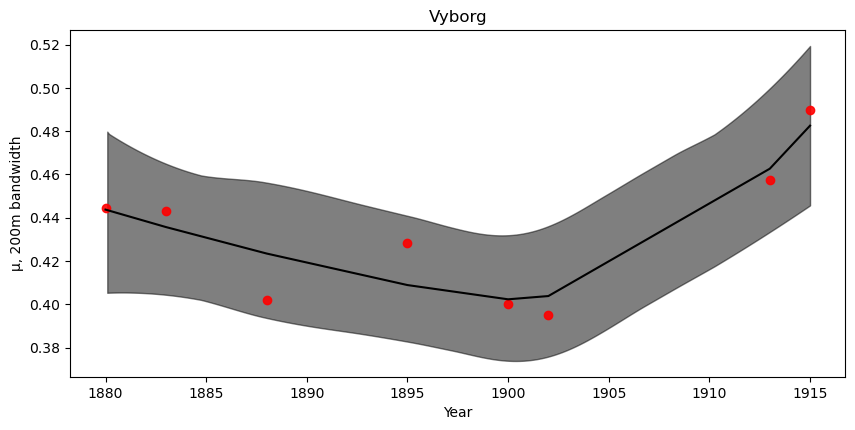

In [23]:
# Posterior mean
ax = az.plot_hdi(regression_data.index, idata["posterior"]["μ"], color="k", hdi_prob=0.95)
ax.plot(regression_data.index, regression_data["200"], "o", c='red', alpha=0.9)
ax.plot(regression_data.index, idata["posterior"]["μ"].mean(axis=(0,1)), c='black')
fig = plt.gcf()
fig.set_size_inches(FIG_SIZE)
ax.set_xlabel("Year")
ax.set_ylabel("μ, 200m bandwidth")
ax.set_title("Vyborg")
plt.savefig(FIG_DIR / 'total.png')
plt.show()

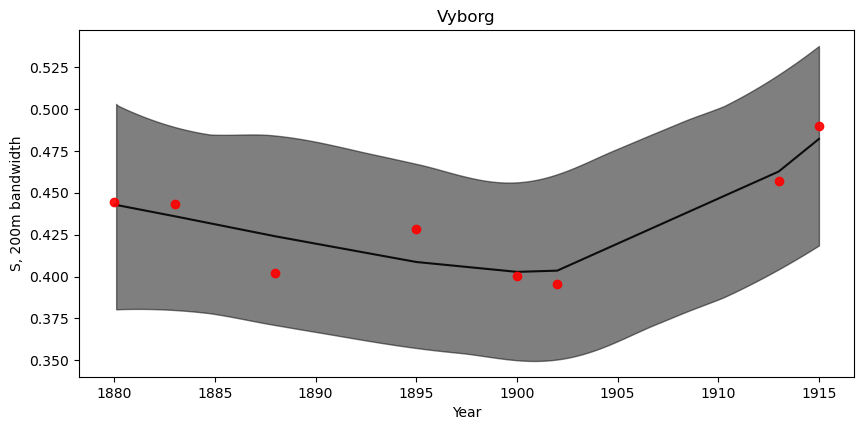

In [24]:
# Posterior predictive
ax = az.plot_hdi(regression_data.index, posterior["posterior_predictive"]["S"], color="k", hdi_prob=0.95)
ax.plot(regression_data.index, posterior["posterior_predictive"]["S"].mean(axis=(0,1)), c='black', alpha=0.9)
ax.plot(regression_data.index, regression_data["200"], "o", c='red', alpha=0.9)
fig = plt.gcf()
fig.set_size_inches(FIG_SIZE)
ax.set_xlabel("Year")
ax.set_ylabel("S, 200m bandwidth")
ax.set_title("Vyborg")
plt.show()

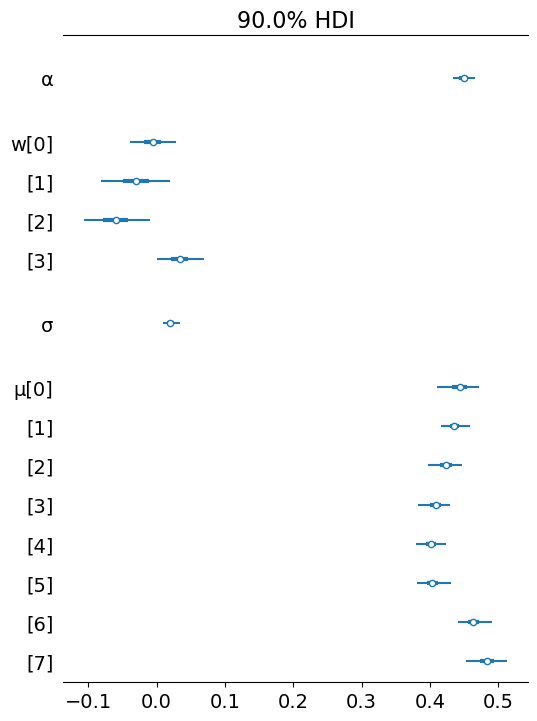

In [25]:
az.plot_forest(idata, hdi_prob=0.9, combined=True)
plt.show()

Total


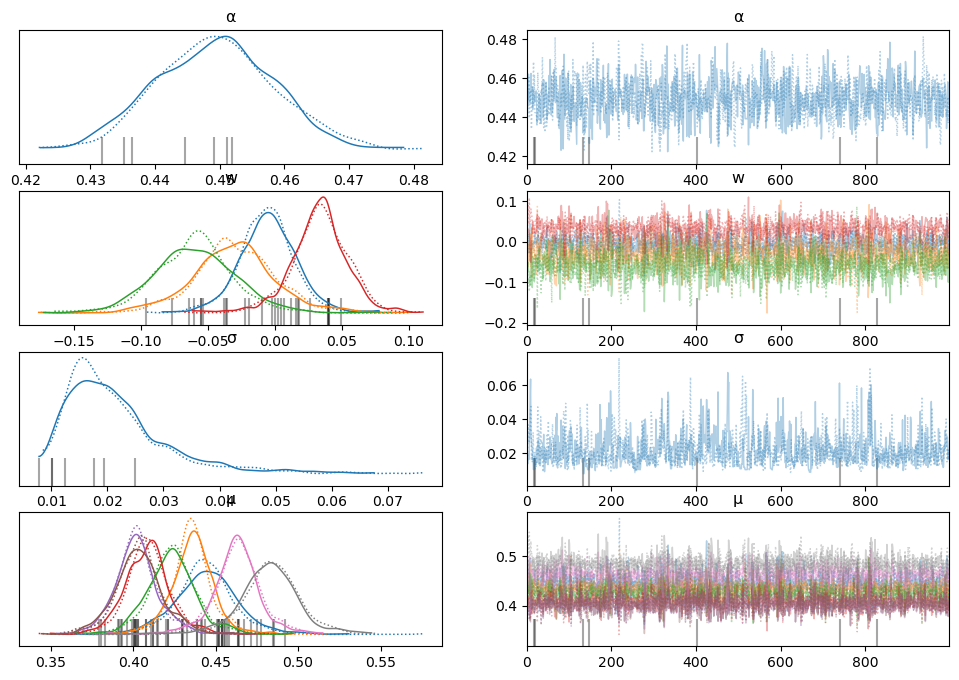

In [26]:
az.plot_trace(idata)
print("Total")
plt.show()

In [27]:
idata_areas = {}
for i, area in enumerate(AREAS):
    with pm.Model() as model_area:
        a = pm.Normal("α", μ_a, σ_a)
        w = pm.Normal("w", mu=μ_w, sigma=σ_w, shape=B.shape[1])
        μ = pm.Deterministic("μ", a + pm.math.dot(np.asarray(B, order="F"), w.T))
        σ = pm.HalfNormal('σ', σ_σ)
        S = pm.Normal("S", μ, σ, observed=results_by_district[area])
        idata_areas[area] = pm.sample(1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α, w, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [28]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.449,0.010,0.430,0.468,0.000,0.000,978.0,1100.0,1.00
w[0],-0.006,0.021,-0.048,0.038,0.001,0.001,1112.0,946.0,1.00
w[1],-0.030,0.032,-0.096,0.034,0.001,0.001,1135.0,1059.0,1.00
w[2],-0.060,0.030,-0.115,0.004,0.001,0.001,1148.0,1066.0,1.01
w[3],0.033,0.021,-0.010,0.075,0.001,0.001,856.0,991.0,1.00
σ,0.022,0.009,0.009,0.040,0.000,0.000,573.0,652.0,1.00
μ[0],0.444,0.019,0.404,0.482,0.001,0.000,1443.0,1093.0,1.00
μ[1],0.436,0.013,0.407,0.461,0.000,0.000,1697.0,1174.0,1.00
μ[2],0.424,0.016,0.393,0.457,0.000,0.000,1328.0,1133.0,1.00
μ[3],0.409,0.014,0.383,0.441,0.000,0.000,1519.0,1045.0,1.00


In [29]:
az.summary(idata_areas['Old town'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.447,0.010,0.430,0.467,0.000,0.000,1550.0,1341.0,1.0
w[0],-0.036,0.029,-0.097,0.021,0.001,0.001,1295.0,962.0,1.0
w[1],-0.079,0.041,-0.160,0.003,0.001,0.001,1026.0,1112.0,1.0
w[2],-0.181,0.044,-0.268,-0.093,0.001,0.001,1020.0,1118.0,1.0
w[3],0.013,0.027,-0.040,0.068,0.001,0.001,1636.0,1267.0,1.0
σ,0.031,0.013,0.012,0.056,0.000,0.000,665.0,696.0,1.0
μ[0],0.411,0.027,0.356,0.469,0.001,0.001,1410.0,1066.0,1.0
μ[1],0.396,0.019,0.358,0.434,0.000,0.000,1822.0,1320.0,1.0
μ[2],0.370,0.021,0.325,0.409,0.001,0.000,1221.0,1206.0,1.0
μ[3],0.332,0.020,0.294,0.374,0.001,0.000,1533.0,1135.0,1.0


In [30]:
az.summary(idata_areas['Vyborg suburb'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.448,0.010,0.429,0.466,0.000,0.000,2231.0,1486.0,1.0
w[0],-0.120,0.040,-0.197,-0.043,0.001,0.001,2261.0,1609.0,1.0
w[1],-0.064,0.058,-0.180,0.040,0.001,0.001,1918.0,1497.0,1.0
w[2],-0.052,0.055,-0.154,0.061,0.001,0.001,1770.0,1558.0,1.0
w[3],-0.020,0.038,-0.095,0.055,0.001,0.001,1840.0,1261.0,1.0
σ,0.052,0.016,0.028,0.086,0.000,0.000,1432.0,1150.0,1.0
μ[0],0.328,0.040,0.250,0.403,0.001,0.001,2237.0,1638.0,1.0
μ[1],0.346,0.028,0.296,0.405,0.001,0.000,2573.0,1414.0,1.0
μ[2],0.369,0.031,0.309,0.429,0.001,0.000,2139.0,1717.0,1.0
μ[3],0.387,0.029,0.333,0.450,0.001,0.000,2374.0,1660.0,1.0


In [31]:
az.summary(idata_areas['New districts'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.451,0.010,0.433,0.470,0.000,0.000,2015.0,1498.0,1.0
w[0],0.081,0.035,0.014,0.149,0.001,0.001,1506.0,1187.0,1.0
w[1],0.055,0.051,-0.056,0.144,0.001,0.001,1531.0,1560.0,1.0
w[2],-0.026,0.051,-0.118,0.080,0.001,0.001,1716.0,1261.0,1.0
w[3],-0.036,0.035,-0.107,0.035,0.001,0.001,2118.0,1594.0,1.0
σ,0.043,0.014,0.021,0.071,0.000,0.000,1184.0,1350.0,1.0
μ[0],0.532,0.034,0.463,0.596,0.001,0.001,1610.0,1228.0,1.0
μ[1],0.523,0.025,0.467,0.567,0.001,0.000,1751.0,1234.0,1.0
μ[2],0.505,0.027,0.454,0.561,0.001,0.000,1714.0,1547.0,1.0
μ[3],0.476,0.024,0.426,0.526,0.001,0.000,2298.0,1428.0,1.0


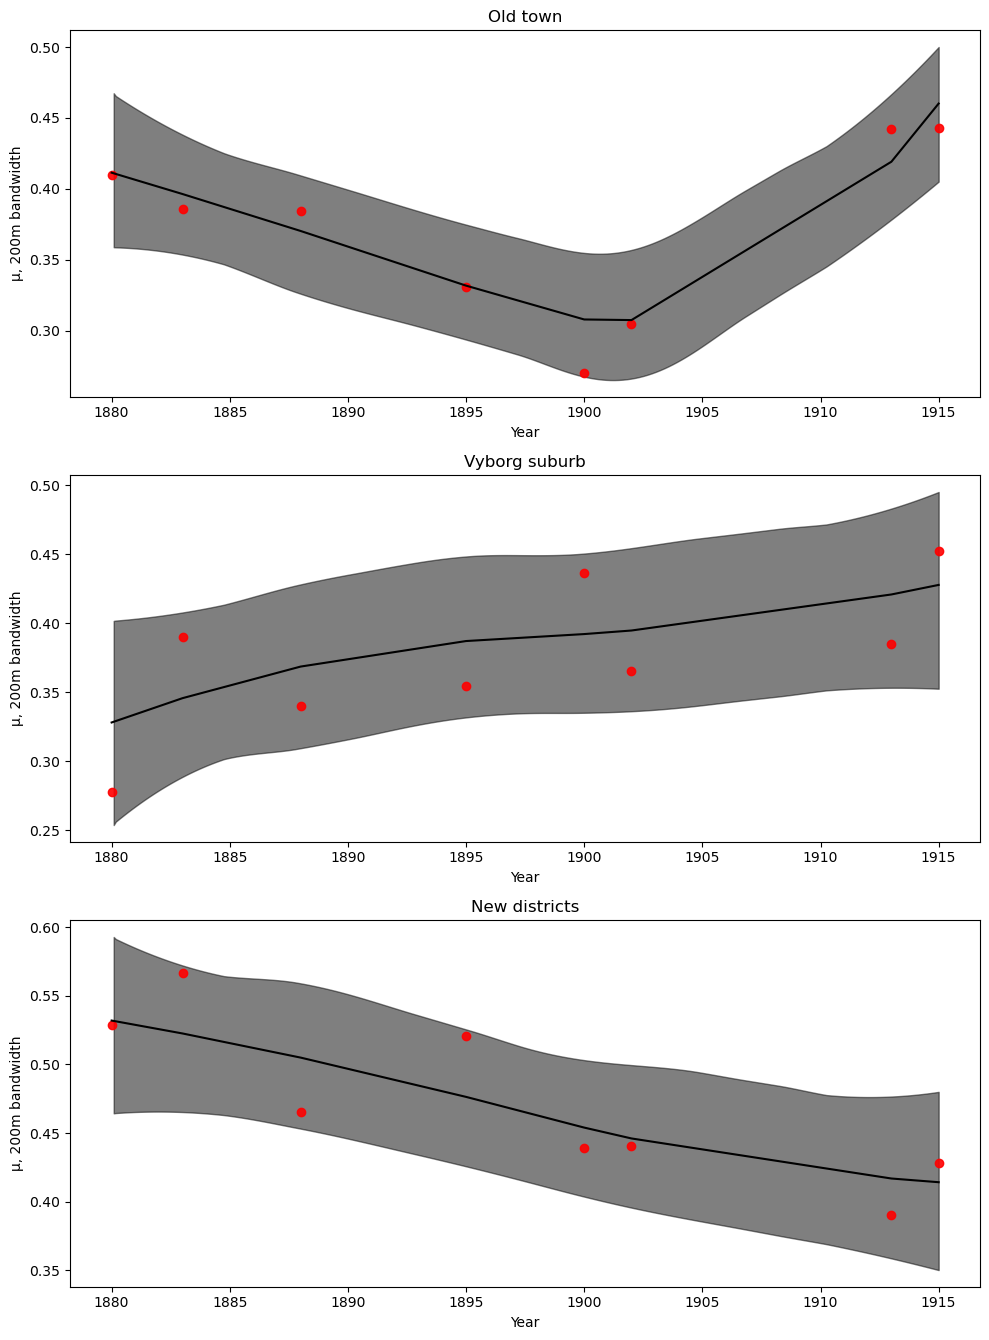

In [32]:
# selected areas    
selected_areas = ["Old town", "Vyborg suburb", "New districts"]
fig, axs = plt.subplots(
    ncols=1, 
    nrows=len(selected_areas),
    figsize=(FIG_SIZE[0], FIG_SIZE[1] * len(selected_areas))
)
for i, area in enumerate(selected_areas):
    mu = idata_areas[area]["posterior"]["μ"]
    az.plot_hdi(regression_data.index, mu, color="k", hdi_prob=0.95, ax=axs[i])
    axs[i].plot(regression_data.index, results_by_district[area], "o", c='red', alpha=0.9)
    axs[i].plot(regression_data.index, mu.mean(axis=(0,1)), c='black')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("μ, 200m bandwidth")
    axs[i].set_title(area)

fig.set_tight_layout(True)
plt.savefig(FIG_DIR / 'all.png')
plt.show()

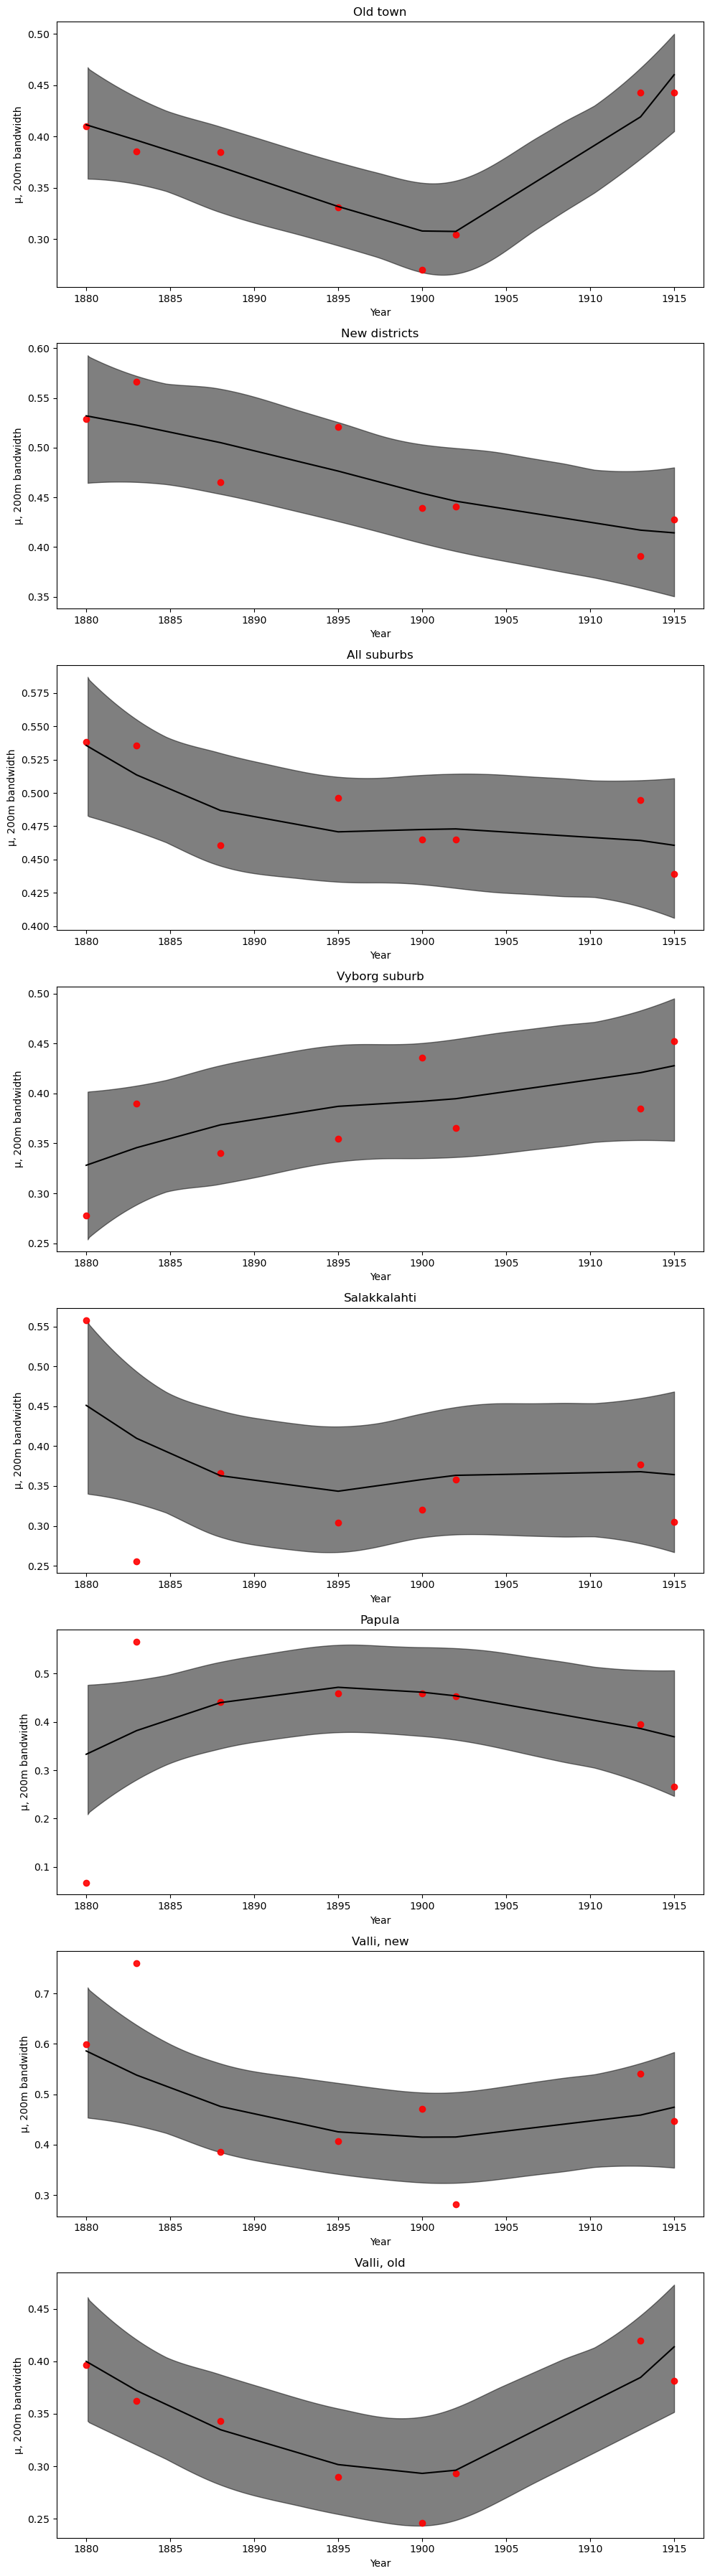

In [33]:
# All areas
fig, axs = plt.subplots(
    ncols=1, 
    nrows=len(AREAS), 
    figsize=(FIG_SIZE[0], FIG_SIZE[1] * len(AREAS)),
)
for i, area in enumerate(AREAS):
    mu = idata_areas[area]["posterior"]["μ"]
    az.plot_hdi(regression_data.index, mu, color="k", hdi_prob=0.95, ax=axs[i])
    axs[i].plot(regression_data.index, results_by_district[area], "o", c='red', alpha=0.9)
    axs[i].plot(regression_data.index, mu.mean(axis=(0,1)), c='black')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("μ, 200m bandwidth")
    axs[i].set_title(area)

fig.set_tight_layout(True)
plt.show()

Old town


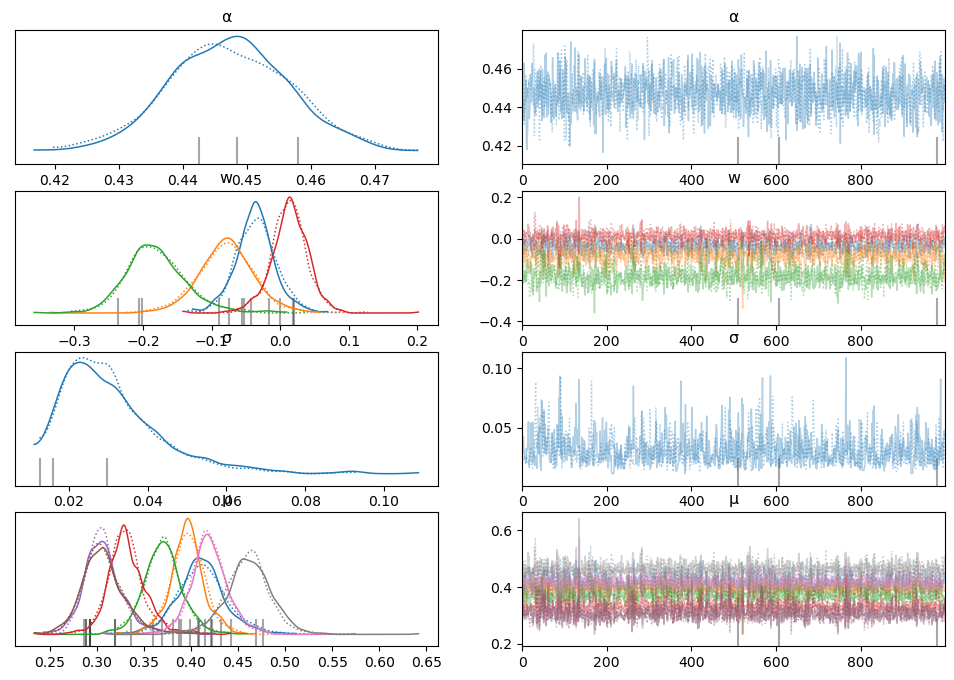

Vyborg suburb


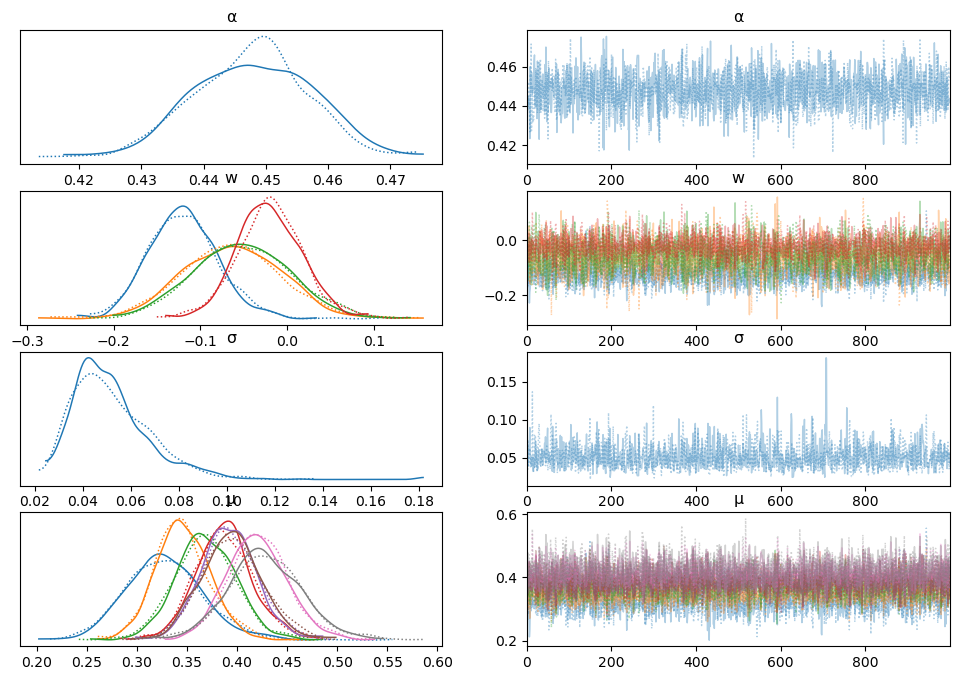

New districts


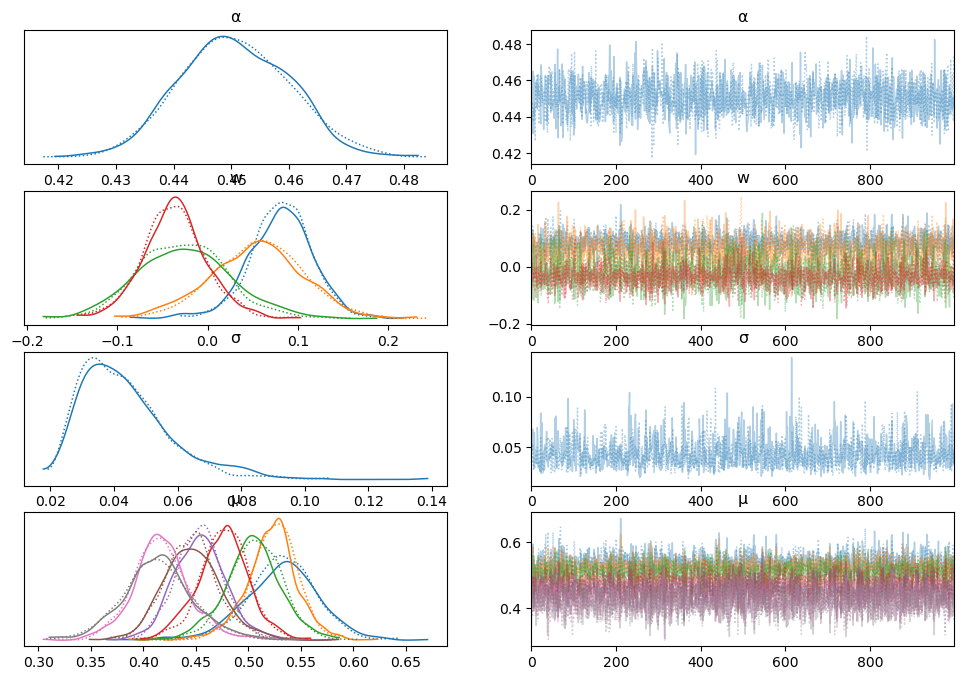

In [34]:
for i, area in enumerate(selected_areas):
    print(area)
    az.plot_trace(idata_areas[area])
    plt.show()

<AxesSubplot: >

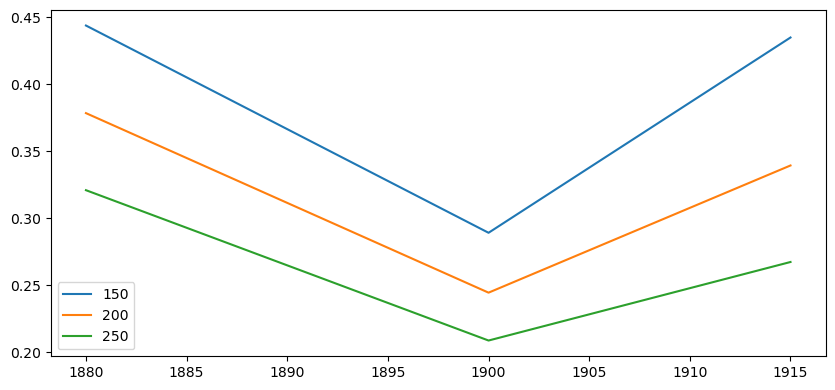

In [35]:
valli_results.plot(figsize=FIG_SIZE)

# Intermarriage

$$ M_i \sim Binom(n_i, p_i) $$
$$ p_i \sim Beta(4, 16) $$
where n_i is the total number of marriages, and p_i is the true outgroup marriage rate during the year i

In [42]:
marriage_data = pd.read_csv(DATA_DIR / 'processed' / 'intermarriage.csv')
intermarriages = marriage_data.loc[marriage_data.area == 'Valli']

In [43]:
coords = {'year': [1880, 1900, 1915]}
with pm.Model(coords=coords) as marriage_model:
    married = pm.ConstantData('n', intermarriages.ingroup_marriages + intermarriages.outgroup_marriages, dims='year')
    p = pm.Beta('p', 4, 16, dims='year')
    mixed = pm.Binomial('M', n=married, p=p, observed=intermarriages.outgroup_marriages, dims='year')
    idata = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


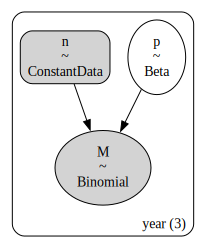

In [44]:
pm.model_to_graphviz(marriage_model)

In [50]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[1880],0.220,0.045,0.145,0.289,0.001,0.0,5810.0,3519.0,1.0
p[1900],0.127,0.036,0.070,0.186,0.000,0.0,5689.0,3082.0,1.0
p[1915],0.093,0.031,0.039,0.137,0.000,0.0,5728.0,3060.0,1.0


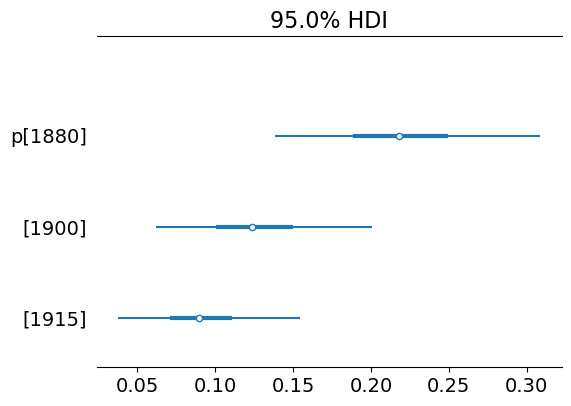

In [46]:
az.plot_forest(idata, combined=True, hdi_prob=0.95)
plt.show()

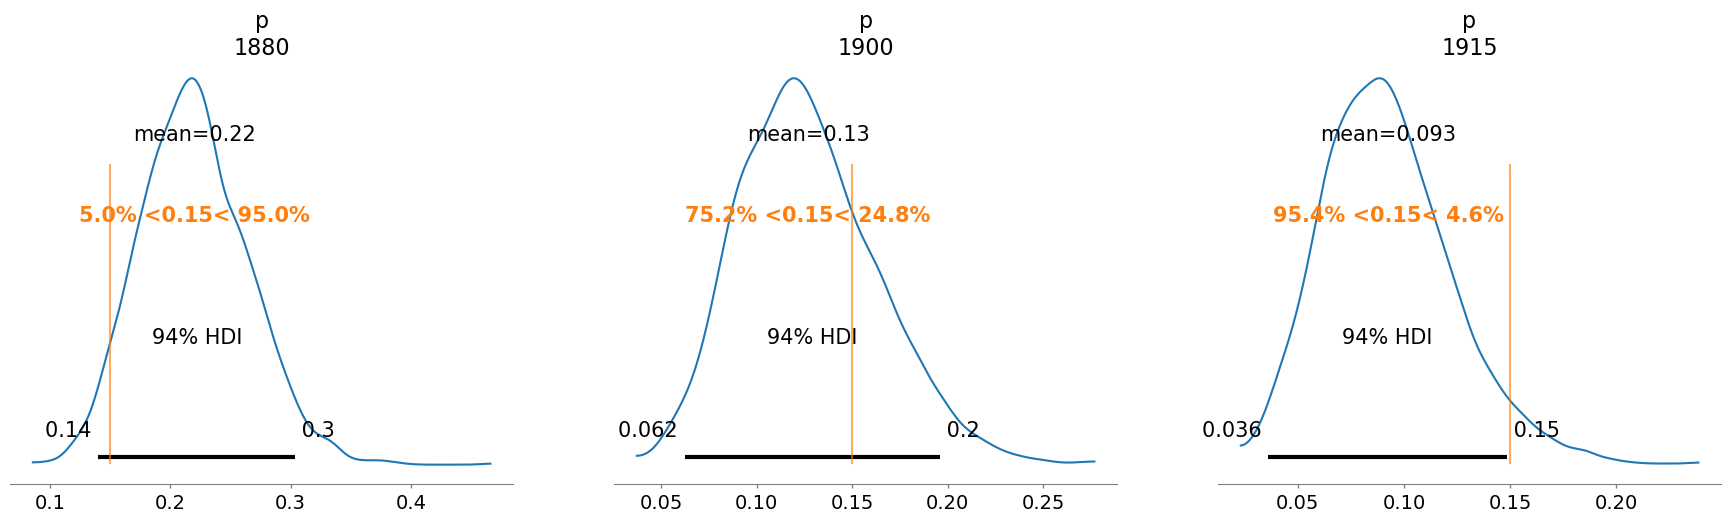

In [49]:
az.plot_posterior(idata, ref_val=0.15)
plt.show()